In [1]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
import sys
sys.path.append("C:/Users/LENOVO/AppData/Local/Programs/Python/Python37/Lib/site-packages")
import librosa
import librosa.display
import scipy

# Algorithm:

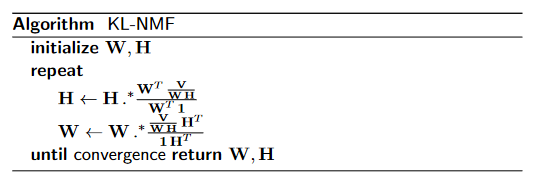

source: https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf

# Decomposition: $V = WH$

$V ∈ R^{F \times T}$ - original non-negative data 

$W ∈ R^{F \times K}$ - matrix of basis vectors, dictionary elements. Not orthonormal, but commonly normalized to one

$H ∈ R^{K \times T}$ - matrix of activations, weights, or gains

In [2]:
# complexity worse case: iterations*fkt
# complexity best case: m*fkt
def NMF(V, K, max_iter=100, eps=0.0001):
    print(V.shape[0], V.shape[1])
    if len(V.shape) < 2:
        F, T = 1, V.shape[0]  
    else:
        F, T = V.shape
    W = np.random.rand(F, K)
    H = np.random.rand(K, T)
    
    ONES = np.ones((F, T))
    diffs = []
    for i in range(max_iter):
        # update activations
        # complexity (fkt)
        wh = np.matmul(W, H)
        # complexity (ft)
        v_div_wh = V / (wh + eps)
        
        H *= np.matmul(W.transpose(), (v_div_wh)) / (np.matmul(W.transpose(), ONES) + eps)
        # update dictionary elements
        W *= np.matmul(V / (wh + eps), H.transpose()) / (np.matmul(ONES, H.transpose()) + eps) 
        
        # ft
        diff = abs(np.linalg.norm(V - wh))
        
        diffs.append(diff)
        if diff <= eps: # convergence at var m
            break
    
    plt.plot(diffs, marker="*")
    plt.show()
    # normalize to sum to 1
    sumW = np.sum(W, axis=0)
    W = np.matmul(W, np.diag(1/sumW))
    H = np.matmul(np.diag(sumW), H)
    #return np.dot(W, H), diffs
    return W, H, diffs

In [3]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time)

2000 3


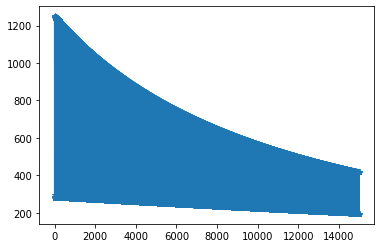

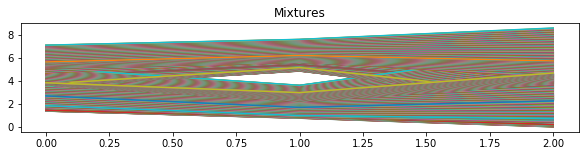

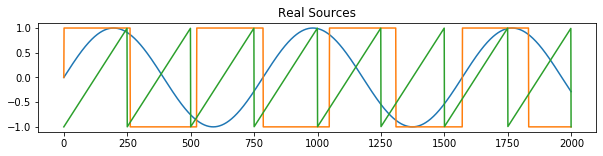

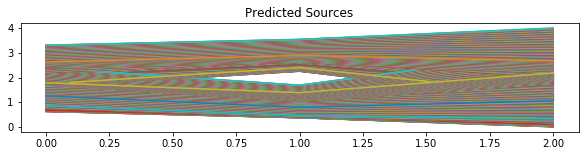

In [5]:
Xhat = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(Xhat, A.T)
X = X.T
# make them all positive
X = X.T + -1 * np.min(X)
w, h , errors = NMF(X, K=3, max_iter=15000)
S = np.dot(w, h)

plt.figure(figsize=(10,2))
plt.title("Mixtures")
for i in range(len(X)):
    plt.plot(X[i])
    
plt.figure(figsize=(10,2))
plt.title("Real Sources")
a = [s1, s2, s3]
for i in range(len(a)):
    plt.plot(a[i])
    
plt.figure(figsize=(10,2))
plt.title("Predicted Sources")
for i in range(len(S)):
    plt.plot(S[i])

# Smush all the signals into one:

In [ ]:
X = np.c_[s1, s2, s3]
X = X.T 
print(X.shape)

Y = np.sum(X, axis=0) 
Y += -1 * np.min(Y)
print(Y.shape)

plt.figure(figsize=(10,2))
for i in range(3):
    plt.plot(X[i])
    
plt.figure(figsize=(10,2))
plt.plot(Y)
plt.title("Squished")

In [ ]:
S = librosa.stft(Y)
print(S.shape)
plt.figure()
logX = librosa.amplitude_to_db(np.abs(S))
librosa.display.specshow(logX, sr=0.0005, x_axis='time', y_axis='log')

In [ ]:
n_components = 3
W, H, errors = NMF(np.abs(S), K=n_components, max_iter=20000)
W.shape, H.shape

In [ ]:
# Plot the "basis" vectors i.e. columns of W
plt.figure()
logW = np.log10(W)
for n in range(n_components):
    plt.subplot(np.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-2, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

In [ ]:
# Plot the columns of H i.e. the temporal activations
plt.figure()
for n in range(n_components):
    plt.subplot(np.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

In [ ]:
plt.figure(figsize=(10, 2))
plt.title("Predicted")
for n in range(n_components):
    Y_ = scipy.outer(W[:,n], H[n])* np.exp(1j*np.angle(S))
    y = librosa.istft(Y_)
    plt.plot(y)
    
plt.figure(figsize=(10,2))
plt.title("Original")
for i in range(3):
    plt.plot(X[i])